<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/machine_learning/reinforcement_learning/DQN/dqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q Network with TF-Agents
## Ustawienia

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

In [0]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents

In [0]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [45]:
tf.compat.v1.enable_v2_behavior()

# Ustawienie virtual display do renderowania środowisk OpenAI gym.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [46]:
tf.version.VERSION

'2.1.0'

## Hiperparametry

In [0]:
num_iterations = 20000

initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

## Środowisko

In [48]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.01072969, -0.04692481,  0.00261066, -0.01407667], dtype=float32))

In [49]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [50]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [51]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [52]:
time_step = env.reset()
print('Krok czasowy:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Następny krok czasowy:')
print( next_time_step)

Krok czasowy:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.03928583,  0.04371152, -0.0384336 ,  0.04248301], dtype=float32))
Następny krok czasowy:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04016006,  0.23936293, -0.03758394, -0.26207405], dtype=float32))


In [0]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [0]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

In [0]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Polityki

In [0]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [0]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [0]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [0]:
time_step = example_environment.reset()

In [61]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

## Metryki i ocena

In [0]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0 

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [63]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.4

## Bufor odtwarzania

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

In [65]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [66]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Gromadzenie danych

In [0]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

In [68]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [69]:
iterator = iter(dataset)

print(iterator)

## Trenowanie agenta
Uruchomienie zajmie ok. 5 min.

In [71]:
try:
  %%time
except:
  pass

agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Zgromadzenie kilku kroków z użyciem collect_policy i zapisanie ich do buforu odtwarzania (replay_buffer).
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Próbka wsadu danych z bufora i aktualizacja sieci agenta.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval ==  0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
step = 200: loss = 16.386730194091797
step = 400: loss = 3.9212646484375
step = 600: loss = 15.050577163696289
step = 800: loss = 13.939452171325684
step = 1000: loss = 1.6440515518188477
step = 1000: Average Return = 30.100000381469727
step = 1200: loss = 14.063558578491211
step = 1400: loss = 12.378459930419922
step = 1600: loss = 24.600921630859375
step = 1800: loss = 5.774158477783203
step = 2000: loss = 50.891666412353516
step = 2000: Average Return = 27.899999618530273
step = 2200: loss = 120.42120361328125
step = 2400: loss = 11.712728500366211
step = 2600: loss = 9.029172897338867
step = 2800: loss = 52.36616516113281
step = 3000: loss = 13.247416496276855
step = 3000: Average Return = 33.0
step = 3200: loss = 29.374710083007812
step = 3400: loss = 199.95687866210938
step = 3600: loss = 18.391735076904297
step = 3800: loss = 5.438663959503174
step = 4000: loss = 5.7052178382873535
step = 4000: Average Return = 72.3

## Wizualizacja
### Wykresy

(19.294999599456787, 250.0)

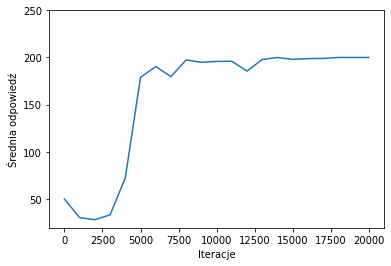

In [72]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Średnia odpowiedź')
plt.xlabel('Iteracje')
plt.ylim(top=250)

### Wideo

In [0]:
def embed_mp4(filename):
  '''Otwiera plik mp4 w notebooku.'''
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [79]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + '.mp4'
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)


create_policy_eval_video(agent.policy, 'trained-agent')

Porównanie (powyższego) przetrenowanego agenta do agenta poruszającego się losowo.

In [80]:
create_policy_eval_video(random_policy, 'random-agent')